In [1]:
import argparse
import json
import logging
import os
import random
import time

import torch
import numpy as np

In [2]:
import sys 
sys.path.append('..')
import utils.misc as ws
import utils.data_utils
import utils.train_utils
import utils.eval_utils
import utils.mesh
import utils.dataset as d
import models.networks as arch


In [3]:
DATA_SOURCE = '/home/ninad/Desktop/Docs/phd-res/proj-irvl-grasp-transfer/code/docker-data/output_dataset/'
# EXPERIMENTS_DIR = '../experiments/epochs_2000_weight_0.5/'
EXPERIMENTS_DIR = '../experiments/all3_multisdf_nogrpemb/'
CHECKPOINT = 'latest'
split_filename = os.path.join(EXPERIMENTS_DIR, 'split_train.json')
specs_filename = os.path.join(EXPERIMENTS_DIR, "specs.json")

LATENT_CODE_DIR = ws.latent_codes_subdir

In [4]:
specs = json.load(open(specs_filename))
latent_size = specs["CodeLength"]
gripper_weight = specs["GripperWeight"]
num_grippers = specs["NumGrippers"]

In [5]:
decoder = arch.MultiSDFDecoder(latent_size, num_grippers+1, **specs["NetworkSpecs"]).cuda()

decoder = torch.nn.DataParallel(decoder)

saved_model_state = torch.load(
    os.path.join(
        EXPERIMENTS_DIR, ws.model_params_subdir, CHECKPOINT + ".pth")
)

saved_model_epoch = saved_model_state["epoch"]

decoder.load_state_dict(saved_model_state["model_state_dict"])

decoder = decoder.module.cuda()

In [6]:
with open(split_filename, "r") as f:
    split = json.load(f)

# npz_filenames = utils.data_utils.dsdf_get_instance_filenames(
#     args.data_source, split)
grp_names, gpc_f, npz_filenames = utils.data_utils.get_instance_filelist(DATA_SOURCE, split)

# random.shuffle(npz_filenames) # WHY??? DISABLE THIS FOR CHECKING REPRODUCIBILITY

In [7]:
for f in npz_filenames:
    print(f[-35:])

df/fetch_gripper/sdf_graspnum_0.npz
df/fetch_gripper/sdf_graspnum_1.npz
df/fetch_gripper/sdf_graspnum_2.npz
df/fetch_gripper/sdf_graspnum_3.npz
df/fetch_gripper/sdf_graspnum_4.npz
df/fetch_gripper/sdf_graspnum_5.npz
df/fetch_gripper/sdf_graspnum_6.npz
df/fetch_gripper/sdf_graspnum_7.npz
df/fetch_gripper/sdf_graspnum_8.npz
df/fetch_gripper/sdf_graspnum_9.npz
f/fetch_gripper/sdf_graspnum_10.npz
f/fetch_gripper/sdf_graspnum_11.npz
f/fetch_gripper/sdf_graspnum_12.npz
f/fetch_gripper/sdf_graspnum_13.npz
f/fetch_gripper/sdf_graspnum_14.npz
f/fetch_gripper/sdf_graspnum_15.npz
f/fetch_gripper/sdf_graspnum_16.npz
f/fetch_gripper/sdf_graspnum_17.npz
f/fetch_gripper/sdf_graspnum_18.npz
f/fetch_gripper/sdf_graspnum_19.npz
f/fetch_gripper/sdf_graspnum_20.npz
f/fetch_gripper/sdf_graspnum_21.npz
f/fetch_gripper/sdf_graspnum_22.npz
f/fetch_gripper/sdf_graspnum_23.npz
f/fetch_gripper/sdf_graspnum_24.npz
f/fetch_gripper/sdf_graspnum_25.npz
f/fetch_gripper/sdf_graspnum_26.npz
f/fetch_gripper/sdf_graspnum

In [8]:
latent_vecs = ws.load_latent_vectors(EXPERIMENTS_DIR, CHECKPOINT)
print(latent_vecs.shape)

torch.Size([120, 256])


In [74]:
index_to_select = random.randint(0, len(npz_filenames)-1)

npz = npz_filenames[index_to_select]

full_filename = npz

print(index_to_select, npz[-35:])


95 0/sdf/HumanHand/sdf_graspnum_15.npz


In [75]:
latent_vec = latent_vecs[index_to_select]

In [76]:
latent_vec = latent_vec.squeeze()
print(latent_vec.shape)

torch.Size([256])


In [77]:
####### MESH RECONSTRUCTION CODE!

is_gripper = True

if is_gripper:
    mesh_filename = os.path.join(EXPERIMENTS_DIR, f'test_{npz[-15:]}')
else:
    mesh_filename = os.path.join(EXPERIMENTS_DIR, f'test_obj_{npz[-15:]}')


latent_vec = latent_vec.squeeze().cuda()
with torch.no_grad():
    utils.mesh.create_mesh_custom(
        decoder, latent_vec, mesh_filename, N=256, max_batch=int(2 ** 18), isGripper=is_gripper, gripper_idx=2)


sampling takes: 11.088969


In [78]:
# IMPORTANT: HAVE SHUFFLE = FALSE SO THAT SAME DATA POINT IS LOADED AS index_to_select

# sdf_dataset = d.SDFSamples(DATA_SOURCE, split, 1000000)

sdf_dataset = d.MultiGripperSamples(DATA_SOURCE, split, 1000000)

sdf_loader = torch.utils.data.DataLoader(
    sdf_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    drop_last=True )

In [79]:
# samples, npzfile = next(iter(sdf_loader))
g_idxs, _, samples, idx, npzfile = sdf_dataset[index_to_select]
print(npzfile[-40:])

queries = samples[:, :3] # Need to pass this through the network
gt_sdf_obj = samples[:, 3].squeeze().numpy()
gt_sdf_grp = samples[:, 4].squeeze().numpy()
print(gt_sdf_grp.shape)

e_1000/sdf/HumanHand/sdf_graspnum_15.npz
(1000000,)


In [42]:
print(g_idxs)

1


In [43]:
sdf_dataset.grp_idxs

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [52]:
print(samples.shape)

torch.Size([1000000, 5])


In [80]:
with torch.no_grad():
    queries, sdf_obj, sdf_grp = utils.eval_utils.eval_query_pc_multisdf(decoder, latent_vec.cuda(), queries, gripper_idx=2)

In [81]:
queries = queries.detach().cpu().numpy()
sdf_obj = sdf_obj.detach().cpu().numpy()
sdf_grp = sdf_grp.detach().cpu().numpy()

In [82]:
print(sdf_grp.shape)
print(sdf_obj.shape)
print(queries.shape)

(1000000,)
(1000000,)
(1000000, 3)


In [83]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def plot_sdf(xyz, sdf, title='Sample_Title', n_display=10000):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')    

    ind = np.random.choice(range(xyz.shape[0]), n_display)
    data = xyz[ind].T

    ax.scatter(data[0], data[2], data[1], s=5, c=sdf[ind])
    ax.view_init(20, 100)
    limit = (-0.95, 0.95)
    ax.set_xlim3d(*limit)
    ax.set_ylim3d(*limit)
    ax.set_zlim3d(*limit)
    plt.title(title)
    plt.show()

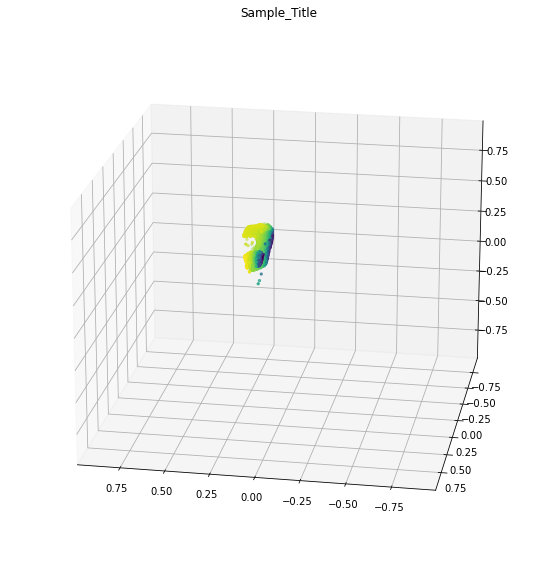

-0.084972754 1.2007561
-0.00031926716 0.9989724


In [85]:
EPS = 0.001
# ind_obj =  np.where((y >= -EPS) & (y <= EPS))
ind_grp = sdf_grp <= EPS

plot_sdf(queries[ind_grp], sdf_obj[ind_grp])

print(min(gt_sdf_grp), max(gt_sdf_grp))
print(min(sdf_grp), max(sdf_grp))

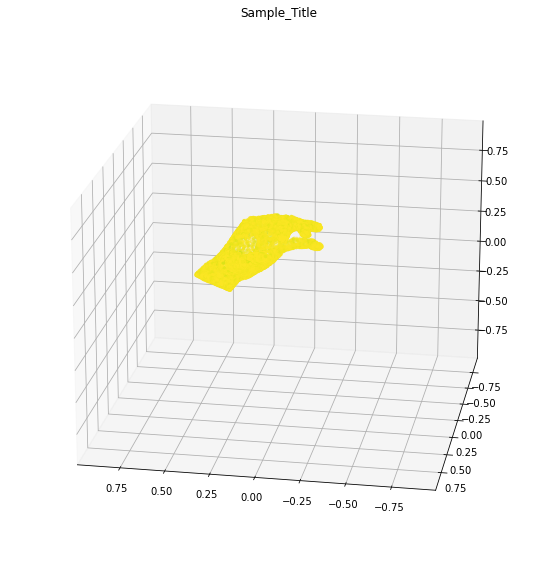

-0.084972754 1.2007561
-0.0021548294 0.7164882


In [86]:
EPS = 1e-5
# ind_obj =  np.where((y >= -EPS) & y <= EPS))
ind_grp = gt_sdf_grp <= EPS

plot_sdf(queries[ind_grp], gt_sdf_grp[ind_grp])

print(min(gt_sdf_grp), max(gt_sdf_grp))
print(min(sdf_obj), max(sdf_obj))

In [67]:
import pyrender
# Just pass the points you want to visualize
def plt_points_3d(pts):
    colors = np.zeros(pts.shape)
    cloud = pyrender.Mesh.from_points(pts, colors=colors)
    scene = pyrender.Scene()
    scene.add(cloud)
    viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)

# Pass the point as well as the sdf to see inside/outside points
def plt_points_sdf(pts, sdf, eps=1e-4):
    colors = np.zeros(pts.shape)
    colors[sdf < eps, 1] = 1
    colors[sdf > eps, 0] = 1
    cloud = pyrender.Mesh.from_points(pts, colors=colors)
    scene = pyrender.Scene()
    scene.add(cloud)
    viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)

def plt_points_sdf_compare(pts, sdf_gt, sdf_pred):
    colors = np.zeros(pts.shape)
    colors[sdf_gt < 0, 1] = 1
    colors[sdf_gt > 0, 0] = 1
    cloud = pyrender.Mesh.from_points(pts, colors=colors)
    scene = pyrender.Scene()
    scene.add(cloud)
    viewer = pyrender.Viewer(scene, use_raymond_lighting=True, point_size=2)
    
    colors2 = np.zeros(pts.shape)
    colors2[sdf_pred < 0, 1] = 1
    colors2[sdf_pred > 0, 0] = 1
    cloud2 = pyrender.Mesh.from_points(pts, colors=colors2)
    scene2 = pyrender.Scene()
    scene2.add(cloud2)
    viewer = pyrender.Viewer(scene2, use_raymond_lighting=True, point_size=2)

In [69]:
plt_points_3d(queries[sdf_grp < 1e-1])

In [32]:
plt_points_3d(queries[sdf_obj < 1e-4])

In [30]:
plt_points_sdf(queries, sdf_grp)

In [ ]:
plt_points_sdf(queries, sdf_obj)